In [78]:
import pandas as pd
from pandas.plotting import table  # For rendering the table
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
#sns.set(color_codes=True)
from IPython.display import clear_output
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

## Data Preparation


###  loading the bikes dataset

In [2]:
# Using pandas read_excel function since the file is an excel file
df = pd.read_excel("biking_dataset.xlsx")
#  To simplify accessing the column names in the analysis, cleaning the name of the columns to keep  every character as lower case and keeping only alpha numeric characters
print(df.columns)
df.columns = [''.join(ch.lower() for ch in column if ch.isalnum()) for column in df.columns]
print(df.columns)

Index(['City', 'Weather Condition', 'Rider Age', 'Bike Model',
       'Ride Duration (min)', 'Distance Covered (km)', 'Rider Satisfaction',
       'Bike Rental Cost ($)'],
      dtype='object')
Index(['city', 'weathercondition', 'riderage', 'bikemodel', 'ridedurationmin',
       'distancecoveredkm', 'ridersatisfaction', 'bikerentalcost'],
      dtype='object')


### Size of the dataset

In [3]:
# Checking the number rows and columns  of the dataset 
# the df.shape shows the number of rows and columns
# There are 900 rows and 8 columns
df.shape

(900, 8)

### Characterizing columns

In [4]:
#
df.dtypes

city                  object
weathercondition      object
riderage             float64
bikemodel             object
ridedurationmin      float64
distancecoveredkm    float64
ridersatisfaction     object
bikerentalcost       float64
dtype: object

| Column Name            | Data Type   | Description                                                                                     |
|------------------------|-------------|-------------------------------------------------------------------------------------------------|
| City                   | Categorical | The main city where the bike ride takes place. Possible values: "New York", "San Francisco", "Chicago", "London", "Berlin". |
| Weather Condition      | Categorical | Weather conditions during the bike ride. Possible values: "Sunny", "Rainy", "Cloudy", "Snowy".  |
| Rider Age              | Numeric     | The age of the rider (in years). Range: 18 to 60.                                               |
| Bike Model             | Categorical | The type of bike used during the ride. Possible values: "Standard", "Electric", "Mountain".      |
| Ride Duration (min)    | Numeric     | The duration of the ride in minutes. Range: 5 to 120 minutes.                                   |
| Distance Covered (km)  | Numeric     | The total distance covered during the bike ride (in kilometers). Range: 0.5 to 40 km.           |
| Rider Satisfaction     | Categorical | The satisfaction level of the rider after the ride. Possible values: "Low", "Medium", "High". This is the target variable for classification tasks. |
| Bike Rental Cost ($)   | Numeric     | The total cost of the bike rental in USD. The value is influenced by factors such as ride duration and bike model. This is the target variable for regression tasks. |

In [5]:
# Splitting the columns as numerical and categorical since some plots and analysis are different between those two groups
# Pandas allow us to select columns by the "dtype" of the column
numeric_columns = df.select_dtypes(include='number').columns
categorical_columns = df.select_dtypes(include='object').columns
print(numeric_columns)
print(categorical_columns)

Index(['riderage', 'ridedurationmin', 'distancecoveredkm', 'bikerentalcost'], dtype='object')
Index(['city', 'weathercondition', 'bikemodel', 'ridersatisfaction'], dtype='object')


### Analysing missing values

In [6]:
# I created a datatframe to summary the missing data per column 
# Reporting missing values per column
# We notice around 1% missing values per column
missing_values = df.isnull().sum()
percentage_mssing_values = (missing_values/len(df))*100
missing_values_df = pd.DataFrame({'Column Name': missing_values.index,
                                  'Missing Values': missing_values.values,
                                  'Percentage Missing Values': percentage_mssing_values.values,
                                 })
missing_values_df

,Column Name,Missing Values,Percentage Missing Values
0,city,10,1.111111
1,weathercondition,11,1.222222
2,riderage,15,1.666667
3,bikemodel,10,1.111111
4,ridedurationmin,13,1.444444
5,distancecoveredkm,13,1.444444
6,ridersatisfaction,11,1.222222
7,bikerentalcost,9,1.000000


In [7]:
# Checking for duplicated rows
df.duplicated().sum()

0

In [8]:
# Do we have specific columns with a lot of missing data ?
# I wanted to know for the rows which have (0, 1 ,2) missing data how much is for a specific column ? 
# Calculate the number of missing values ( we specificy the axis to do it by each row )
# We create a new column Missing Count with this count per row
# and group rows by this count ( we can then for loop to each group and do statistics)

df['Missing Count'] = df.isnull().sum(axis=1)
# Group rows by the number of missing values
grouped = df.groupby('Missing Count')
# Iterate through the groups
for missing_count, group in grouped:
    n_rows = len(group)
    percent = (n_rows/len(df))*100
    print(f"{n_rows} rows ({percent} %) missing {missing_count} value")
    missing_values = group.isnull().sum()
    percentage_mssing_values = (missing_values/len(group))*100
    missing_values_df = pd.DataFrame({'Column Name': missing_values.index,
                                      'Missing Values': missing_values.values,
                                      'Percentage Missing Values': percentage_mssing_values.values,
                                     })
    print(missing_values_df)
    print("\n")
del df['Missing Count']

853 rows (94.77777777777779 %) missing 0 value
         Column Name  Missing Values  Percentage Missing Values
0               city               0                        0.0
1   weathercondition               0                        0.0
2           riderage               0                        0.0
3          bikemodel               0                        0.0
4    ridedurationmin               0                        0.0
5  distancecoveredkm               0                        0.0
6  ridersatisfaction               0                        0.0
7     bikerentalcost               0                        0.0
8      Missing Count               0                        0.0


3 rows (0.33333333333333337 %) missing 1 value
         Column Name  Missing Values  Percentage Missing Values
0               city               0                   0.000000
1   weathercondition               0                   0.000000
2           riderage               0                   0.000000
3       

In [9]:
# dropping any missing value
# 5% of rows are missing at least one value
# there are 42 rows with missing 2 values and they are spread across multiple columns
# The cost of removing 5% of rows seems reasonable compared to the effort of deciding how to fill the missing values for many different situtations
df_any_missing_value = df.dropna()
print(df.shape, df_any_missing_value.shape,47/900)

(900, 8) (853, 8) 0.052222222222222225


In [10]:
cleaned_df = df_any_missing_value

### Exploratory Data Analysis

#### Univariate Data Analysis

In [11]:
# describing numerical variables
print("\tSummary Statistics of Numerical Variables")
cleaned_df.describe()

	Summary Statistics of Numerical Variables


,riderage,ridedurationmin,distancecoveredkm,bikerentalcost
count,853.000000,853.00000,853.000000,853.000000
mean,39.262603,61.76905,20.152016,26.564033
std,12.332311,34.18023,11.226650,9.501788
min,18.000000,5.00000,0.510000,7.330000
25%,29.000000,32.00000,10.750000,19.110000
50%,39.000000,62.00000,19.990000,27.080000
75%,50.000000,92.00000,29.200000,34.010000
max,60.000000,120.00000,39.870000,48.380000


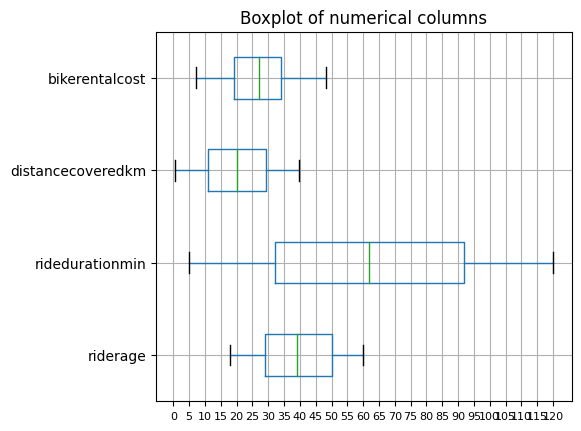

In [12]:
# using this example : https://stackoverflow.com/questions/18500011/horizontal-box-plots-in-matplotlib-pandas
# The boxplot helps us visualiz the distribution of numerical columns
# together with the summary table it gives a general view of each column
df[numeric_columns].boxplot(vert=False)
plt.subplots_adjust(left=0.25)
plt.xticks(range(0, int(df[numeric_columns].max().max()) + 1, 5),fontsize=8)
plt.title("Boxplot of numerical columns")
plt.show()


In [13]:
# describing categorical variables
# This table gives us the intuition most categorical variables have a few categories only
# and together with the bar plot it shows that those categories are reasonably uniform
cleaned_df.describe(include='object')

,city,weathercondition,bikemodel,ridersatisfaction
count,853,853,853,853
unique,6,4,4,3
top,London,Rainy,Electric,High
freq,183,238,285,307


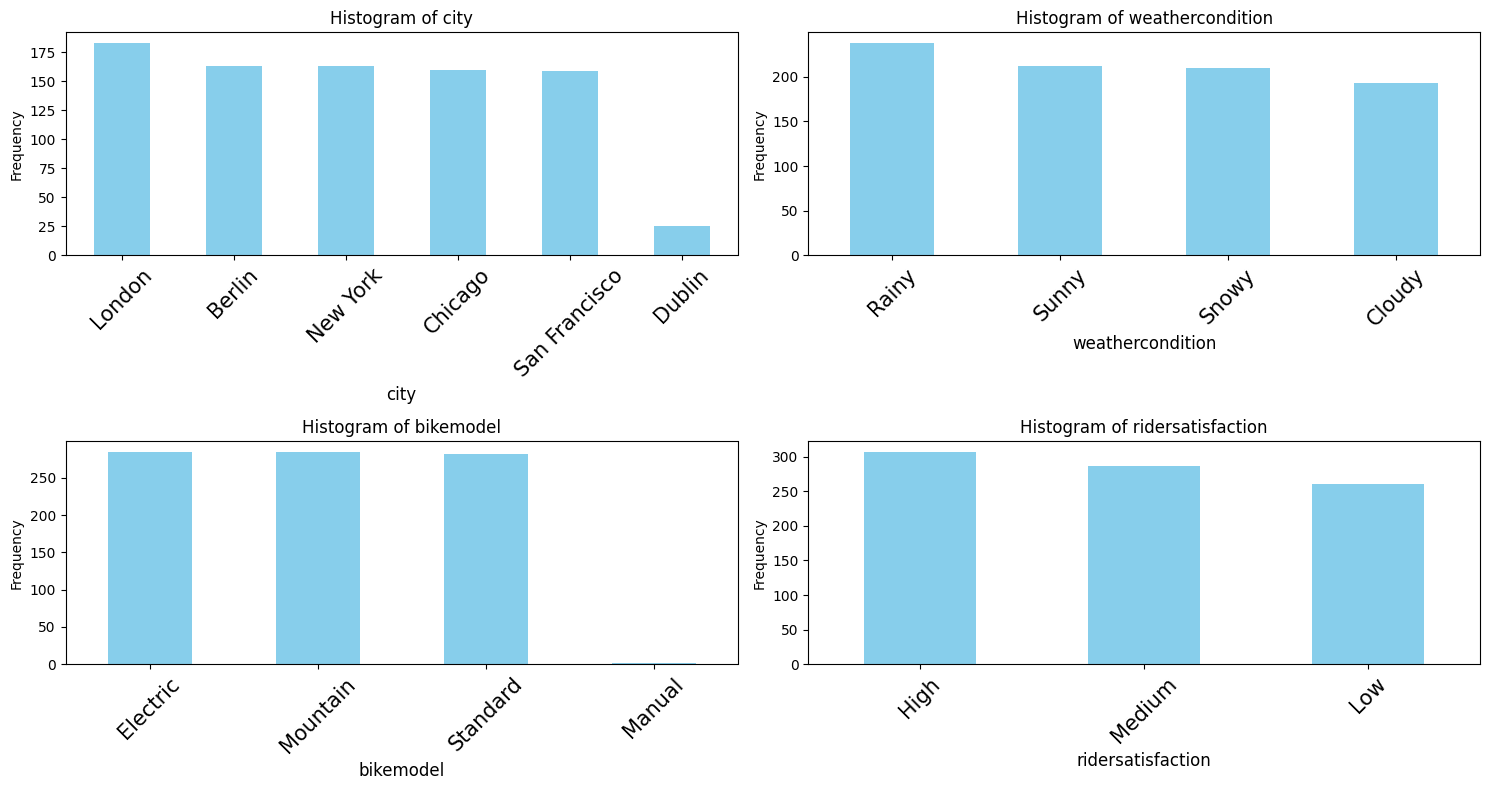

In [14]:
# creating a subplot with 4 (2x2) plots to show the distribution of categories in dataset
# then for each categorical column plot the bar plot
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    # Plot the bar chart on the corresponding subplot
    cleaned_df[column].value_counts().plot(kind='bar', color='skyblue', ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column,fontsize=12)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45,labelsize=15)

plt.tight_layout()
plt.show()

In [15]:
# Droping the only row which contains bikemodel == "manual"
# using example https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value
cleaned_df = cleaned_df[ cleaned_df["bikemodel"] != "Manual" ]

#### Bivariate analysis

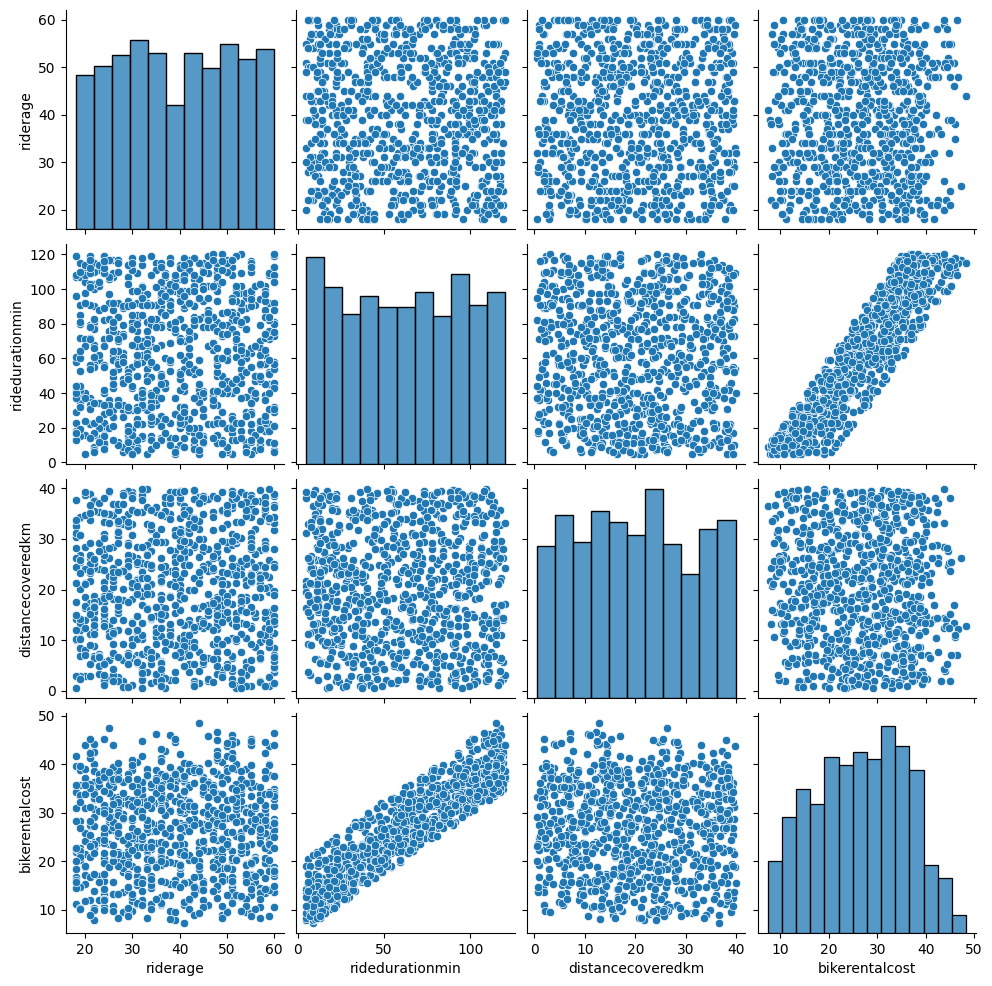

In [16]:
# Bivariate analysis of numerical columns
# Here we plot pairplots for each pair of numerical columns 
# with the goal of understandaing the relationship between nui variables
# there is a clear linear relationship bike rental cost and duration (which is intuitive)
# but all other numerical variables does not have an inutitive relationship
sns.pairplot(cleaned_df[numeric_columns])

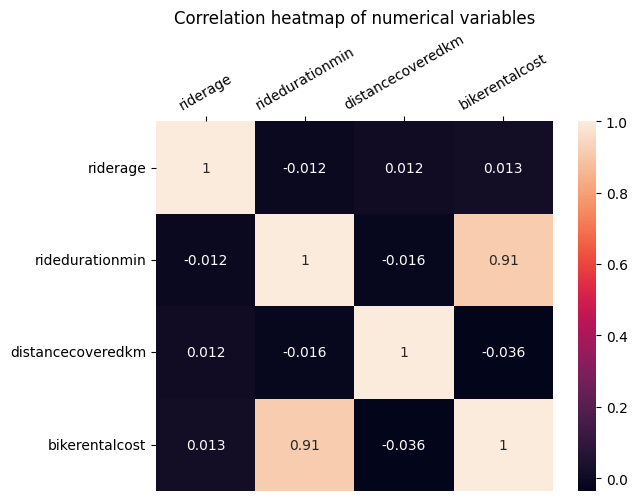

In [17]:
cleaned_df[numeric_columns].corr()
ax = sns.heatmap(cleaned_df[numeric_columns].corr(), annot=True)
ax.set(xlabel="", ylabel="")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
ax.set_title("Correlation heatmap of numerical variables")
ax.xaxis.tick_top()


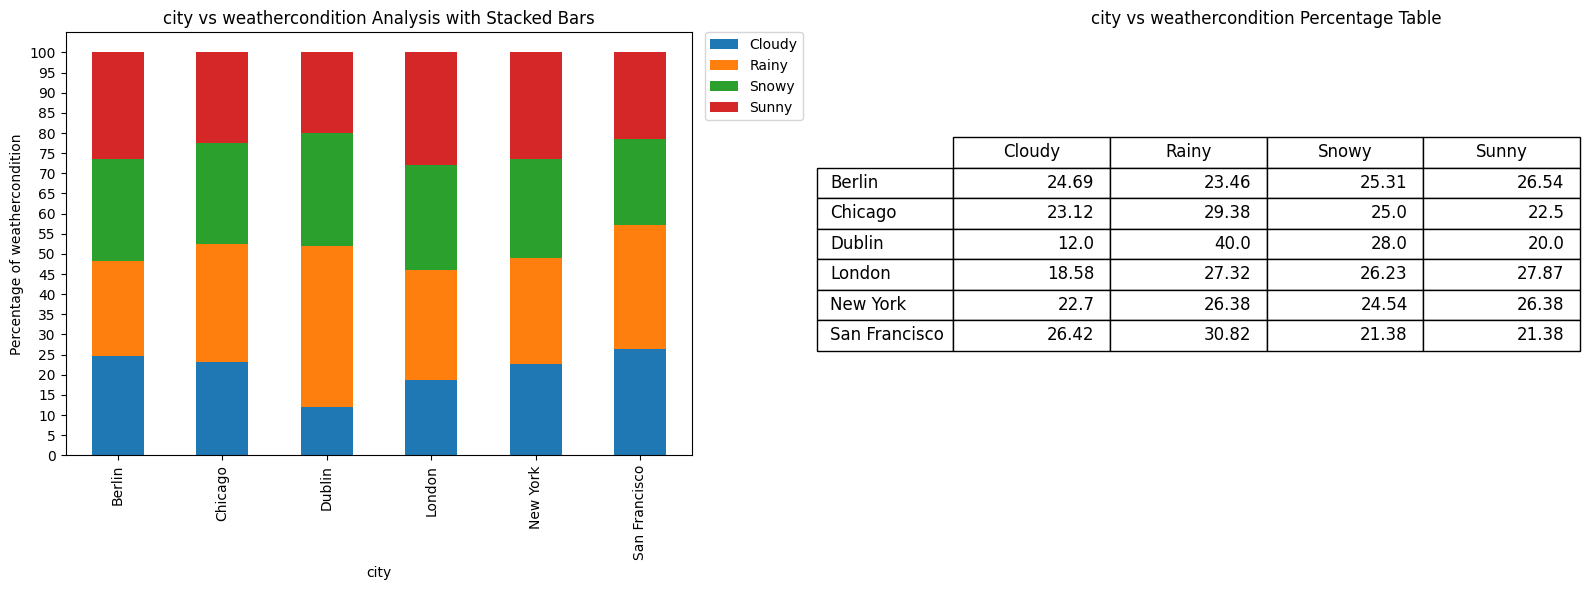

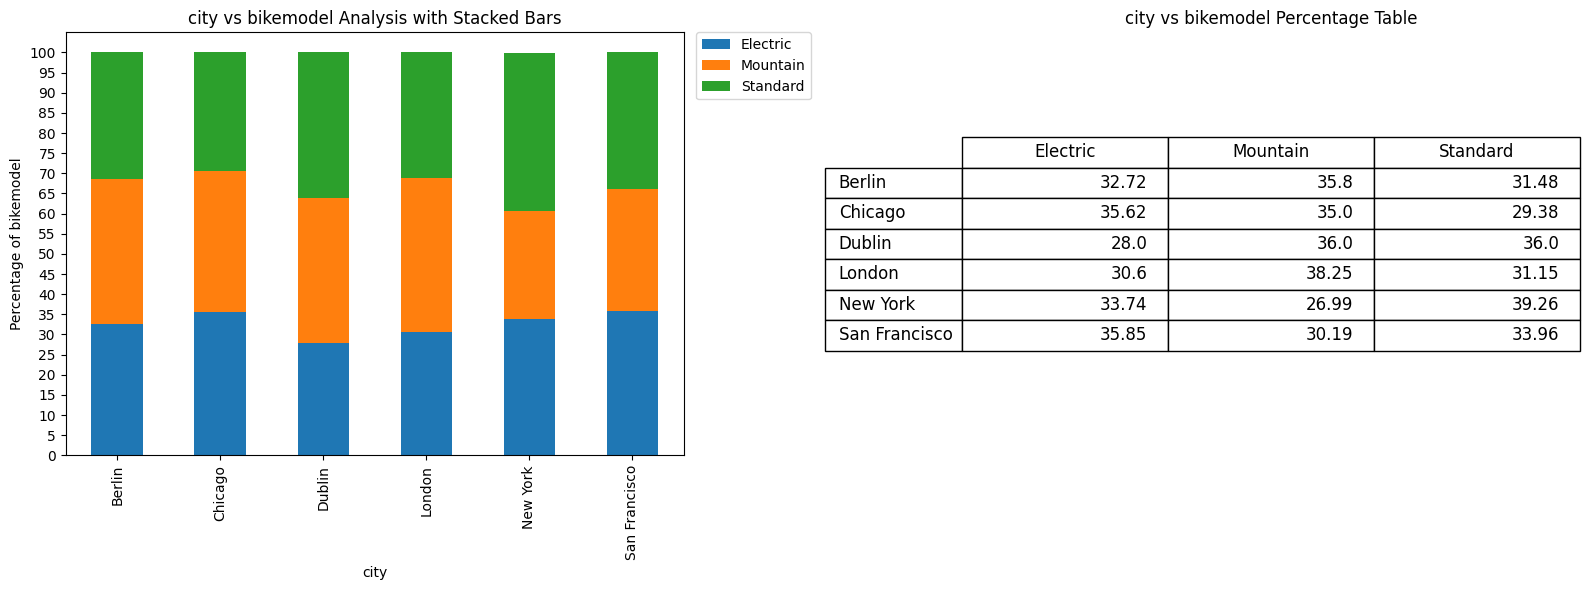

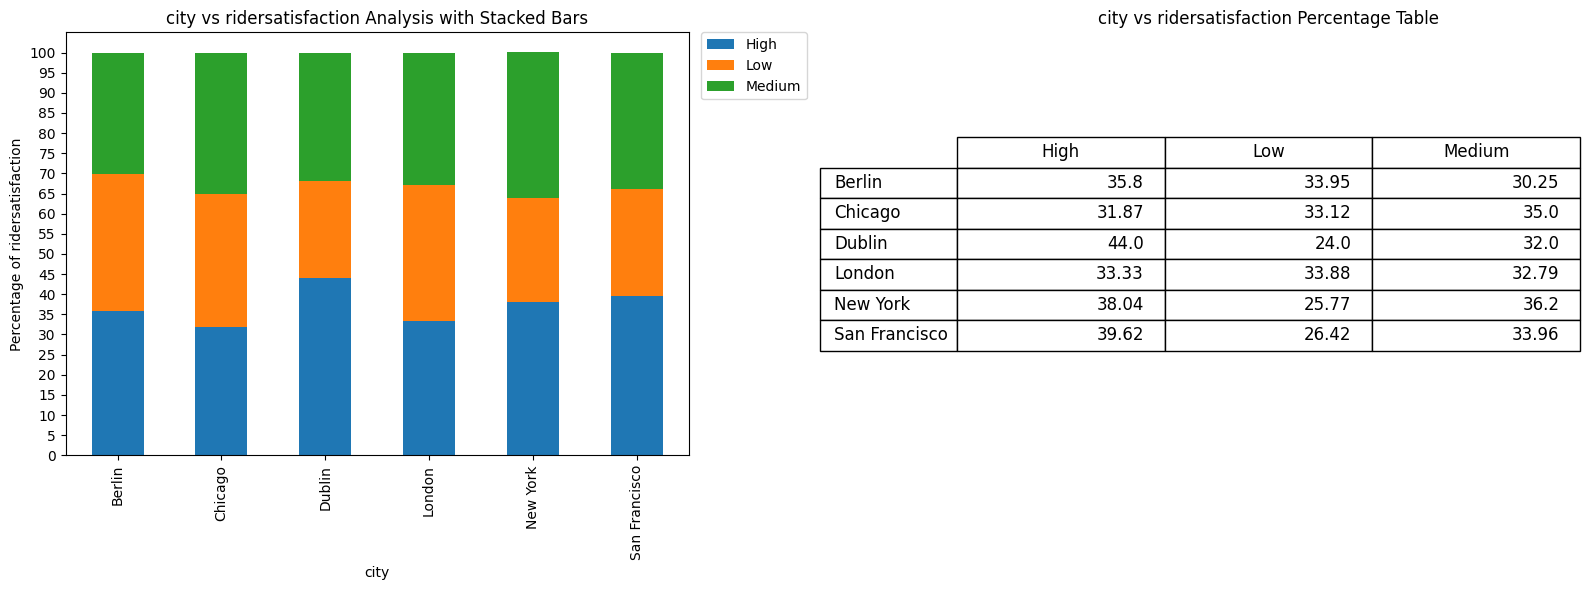

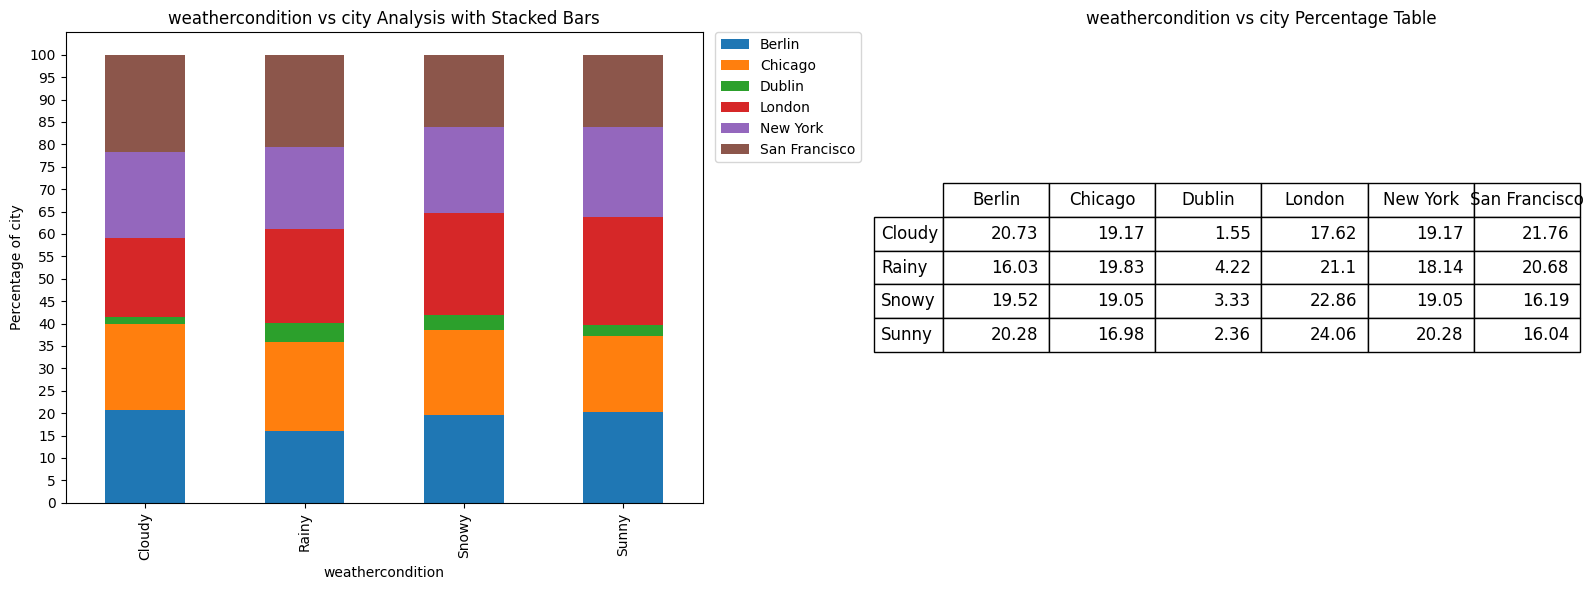

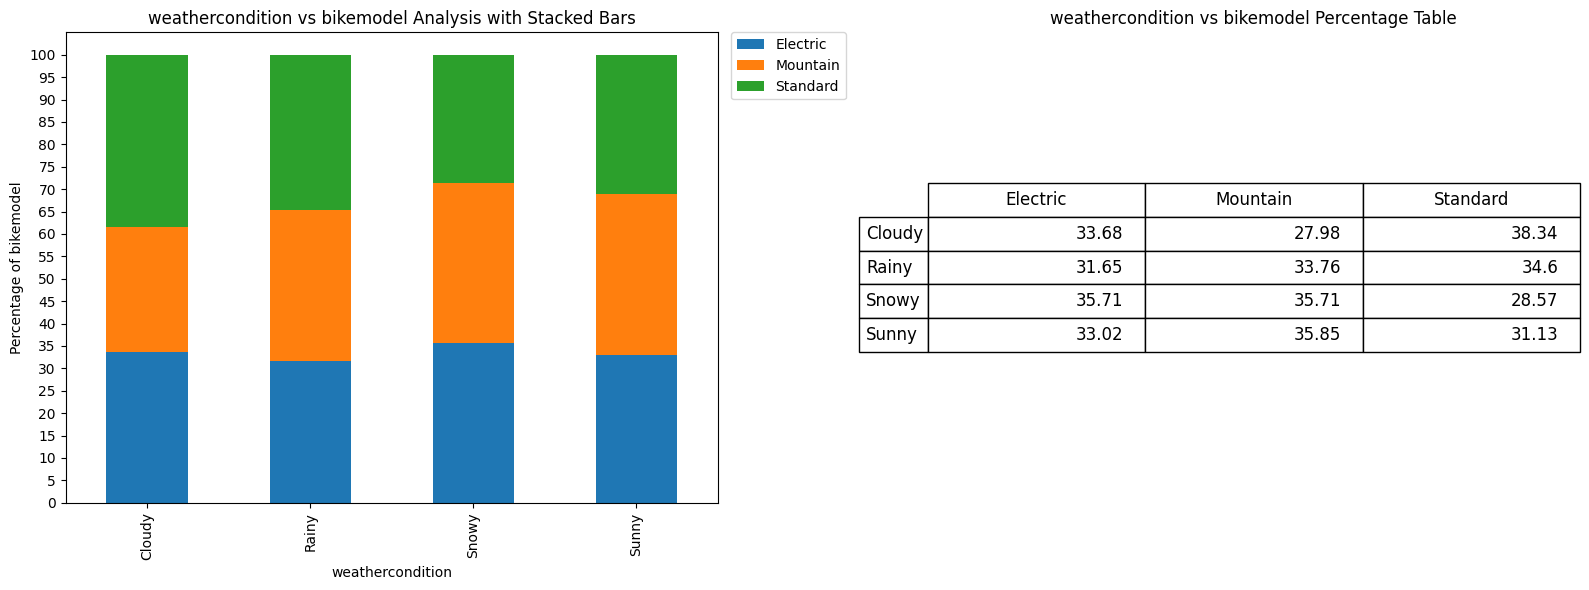

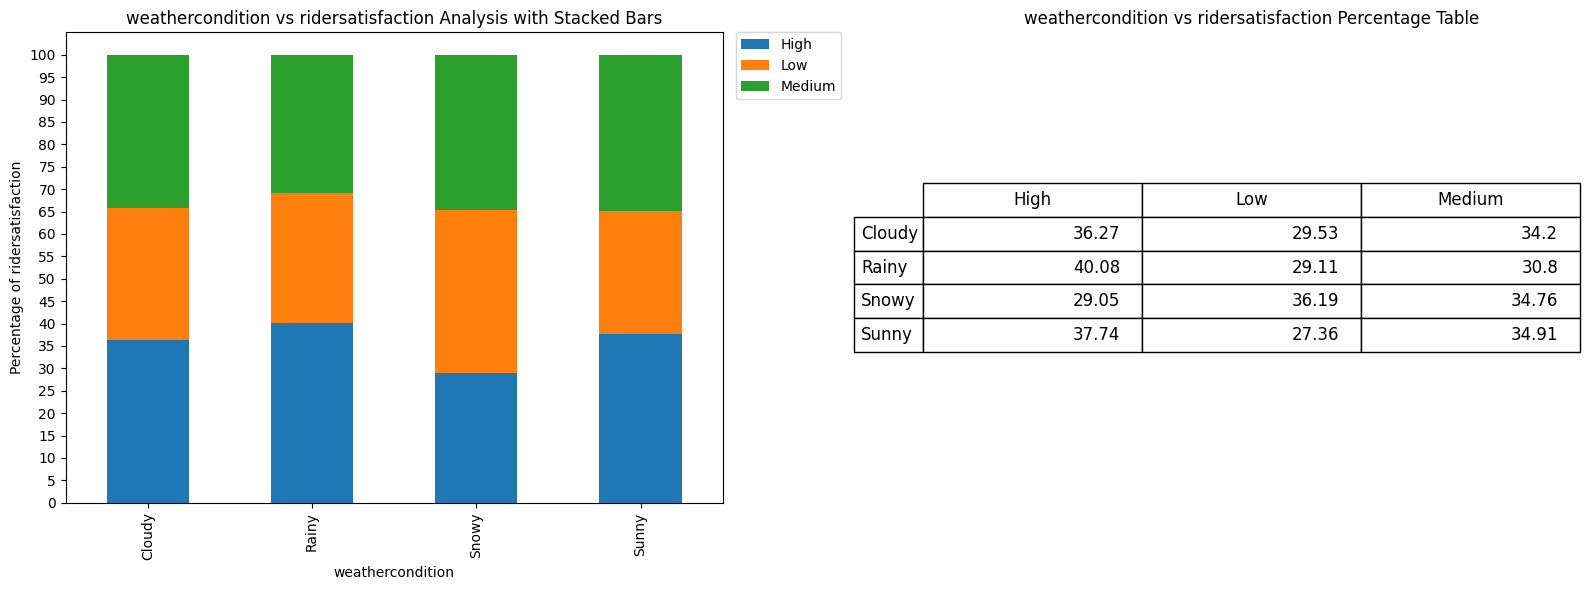

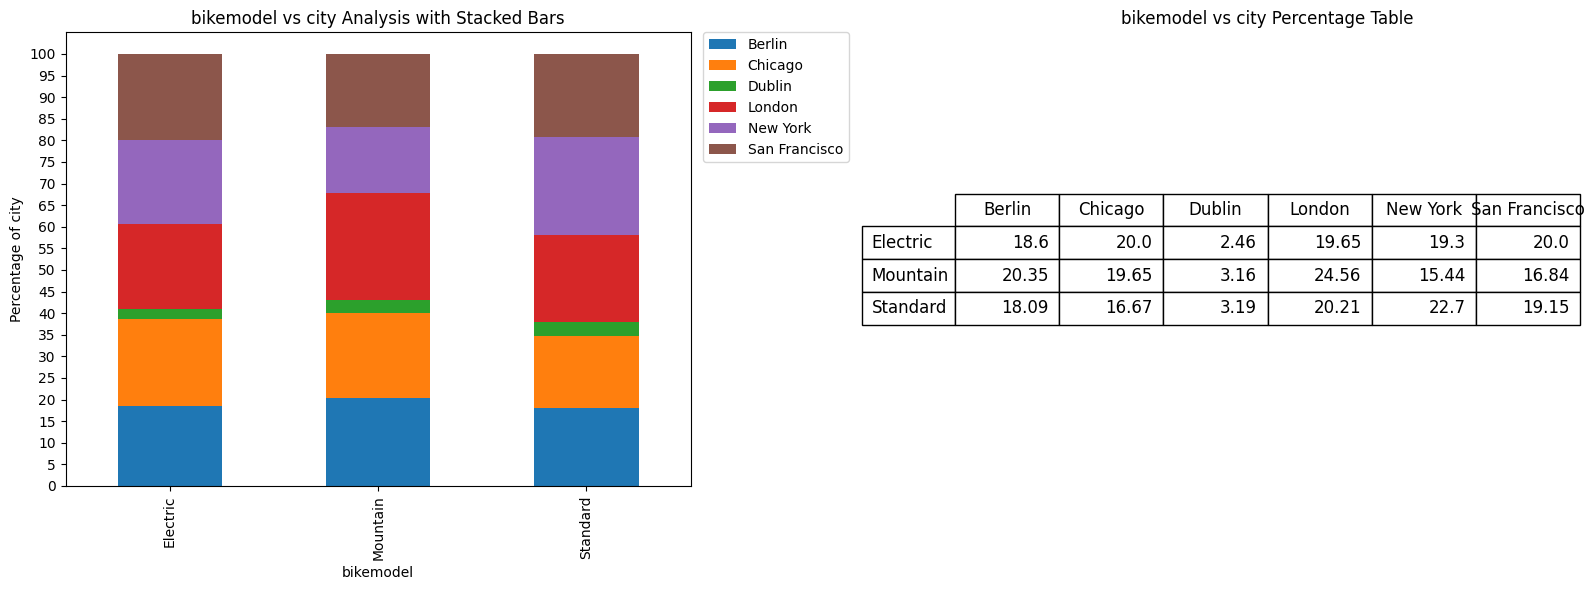

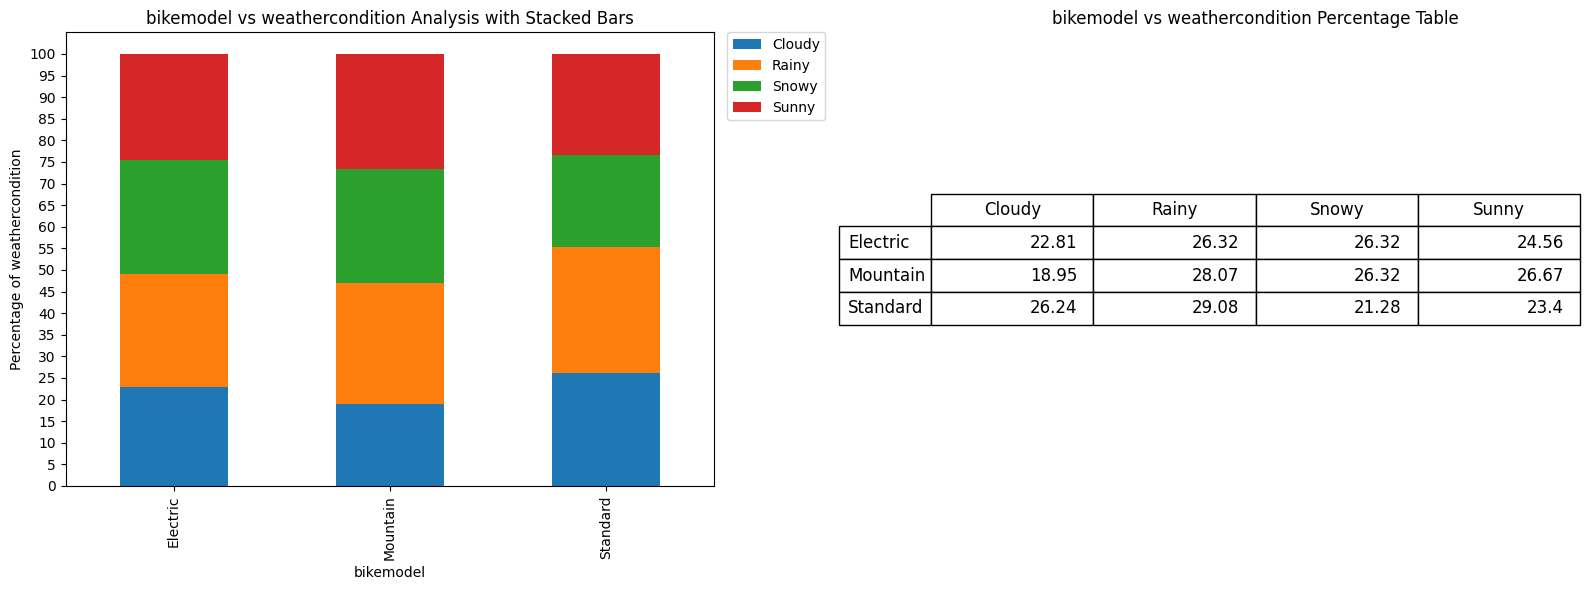

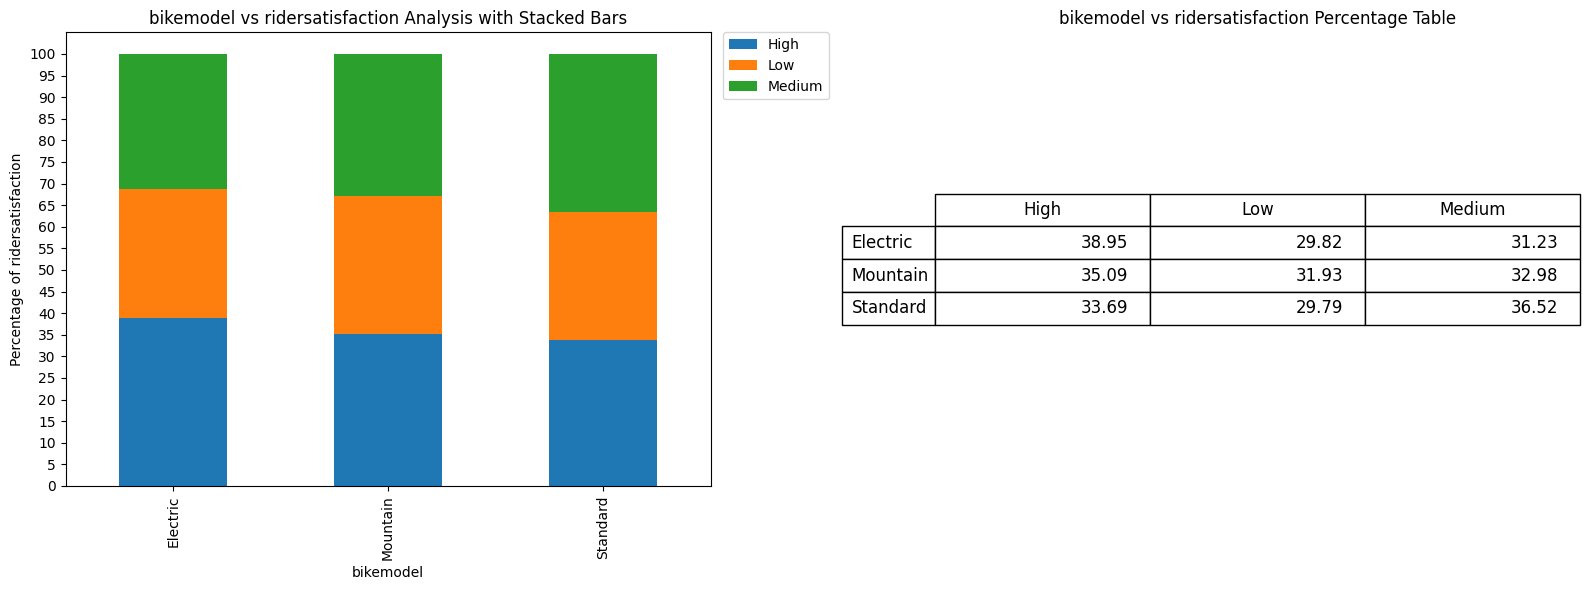

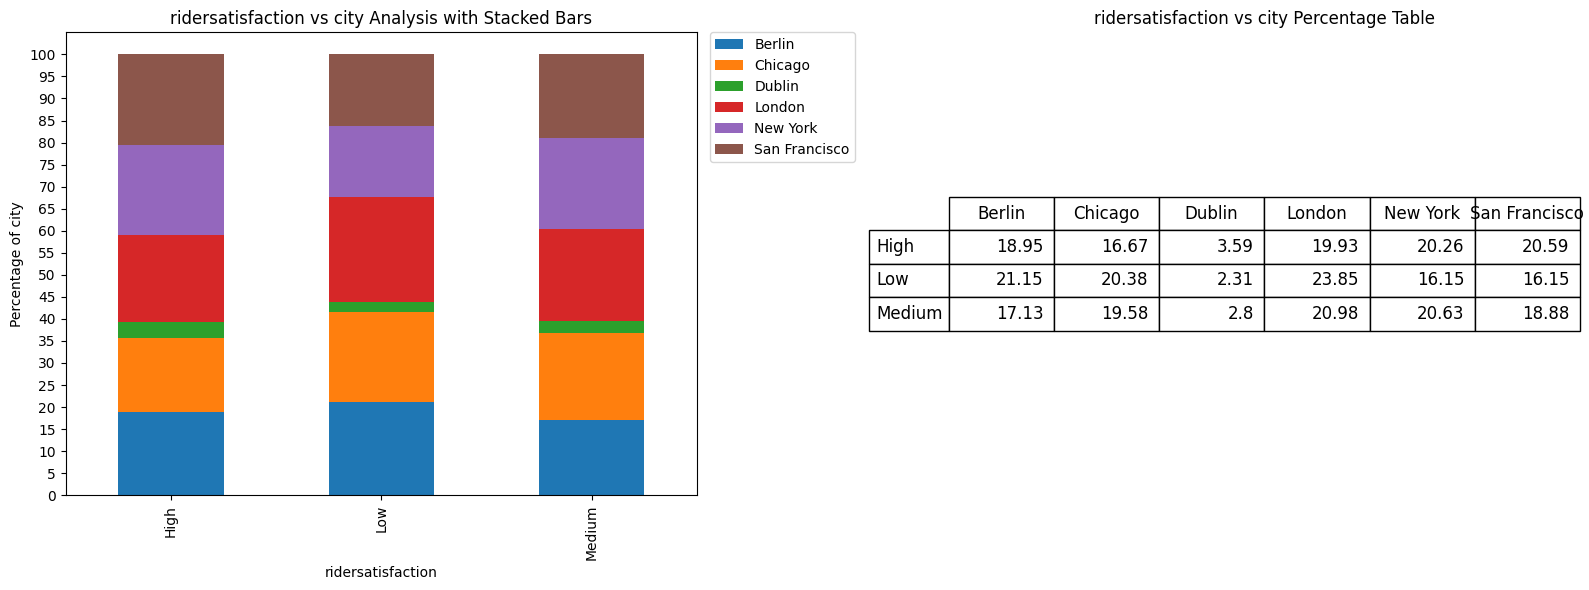

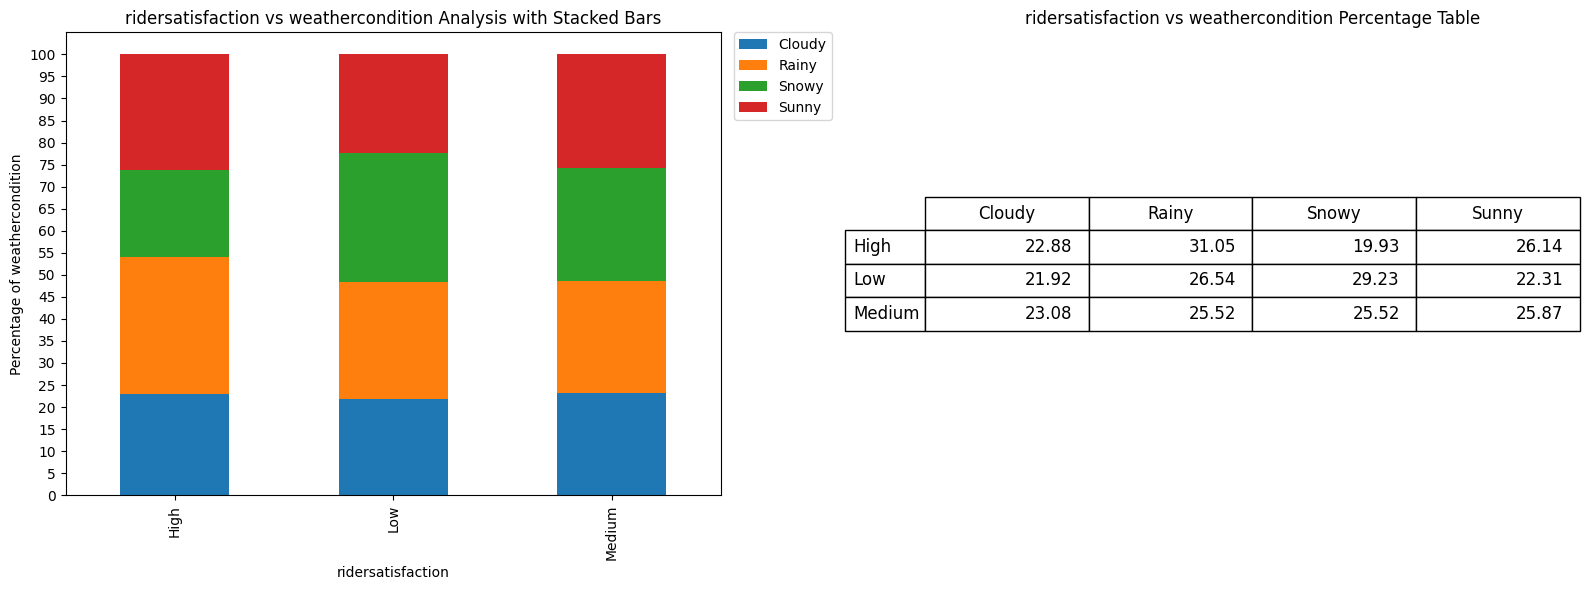

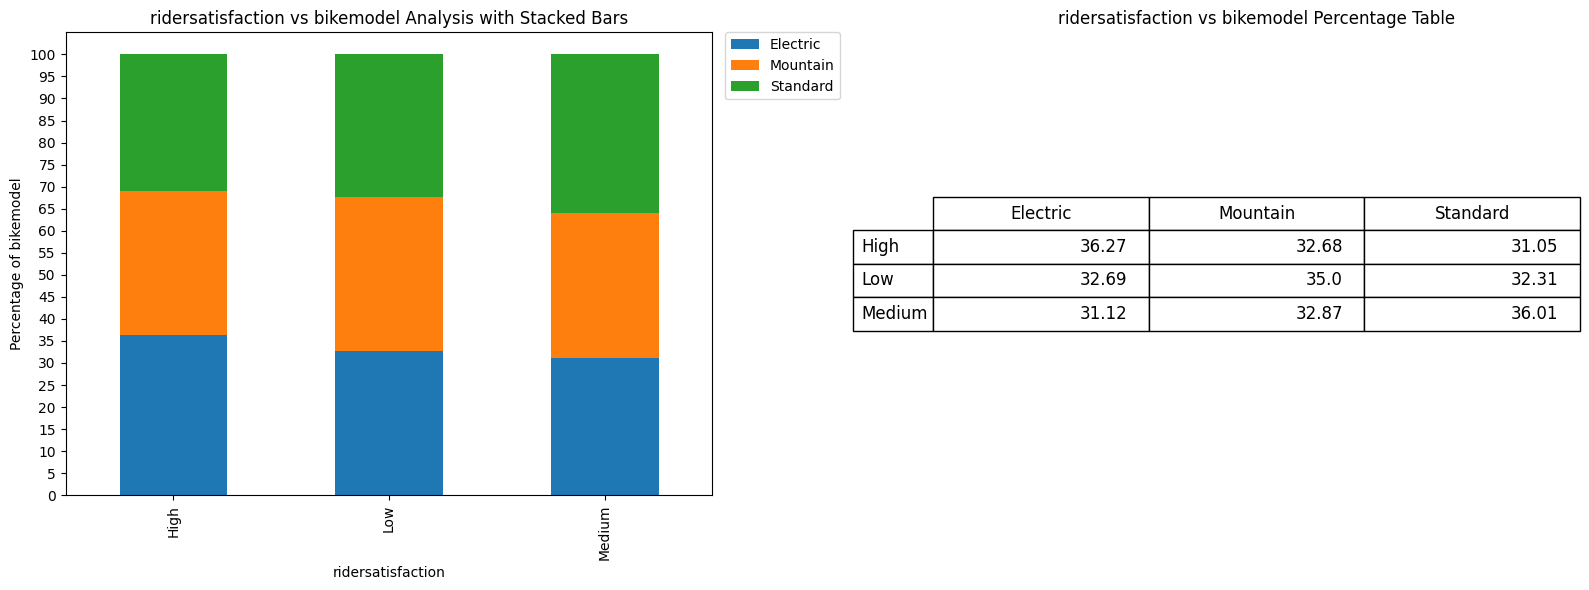

In [18]:
# Analyzing the relationship between categorical variables
# The intuition is to find pair of categories that have a big proportion of some value
# For example : Dublin should have a little bit more rain than hte average ?
# 40% of the  ride on rainy days are in dublin


# Eletric bikes are the ones with higher satistcation ?
# 38.95%  vs 33.69 (standard) 
# Implementation :
# Loop through categorical columns for every pair of category column
# select the columns, 
# use the crosstab function to calculate frequency counts
# use the frequency to calculate teh percentage by dividing by the total of each category of column 1
# multiply by 100 to become a percentage 
for i in range(len(categorical_columns)):
    for j in range(len(categorical_columns)):
        col1 = categorical_columns[i]
        col2 = categorical_columns[j]
        if col1 != col2:
            # Categorical vs Categorical Analysis with Stacked Bars
            cross_tab = pd.crosstab(cleaned_df[col1], cleaned_df[col2])
            row_totals = cross_tab.sum(axis=1)  # Sum of each row
            percentage_table = round(cross_tab.div(row_totals, axis=0) * 100,2)  # Convert to percentages
            max_y = cross_tab.sum(axis=1).max()  # Find the maximum y-value

            # Create a figure with two subplots side by side
            fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 6))

            # Plot the table on the left subplot
            ax1.axis('off') 
            ax1.set_title(f'{col1} vs {col2} Percentage Table')
            tbl = table(ax1, percentage_table, loc='center') 
            tbl.auto_set_font_size(False)
            tbl.set_fontsize(12)
            tbl.scale(1, 2)

            # Plot the stacked bar chart on the right subplot
            percentage_table.plot(kind='bar', stacked=True, ax=ax2)
            ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
            ax2.set_title(f'{col1} vs {col2} Analysis with Stacked Bars')
            ax2.set_xlabel(f'{col1}')
            ax2.set_ylabel(f'Percentage of {col2}')
            ax2.set_yticks(range(0, 101, 5))  # Set y-ticks every 5

            plt.tight_layout()  # Adjust layout to prevent overlap
            plt.show()


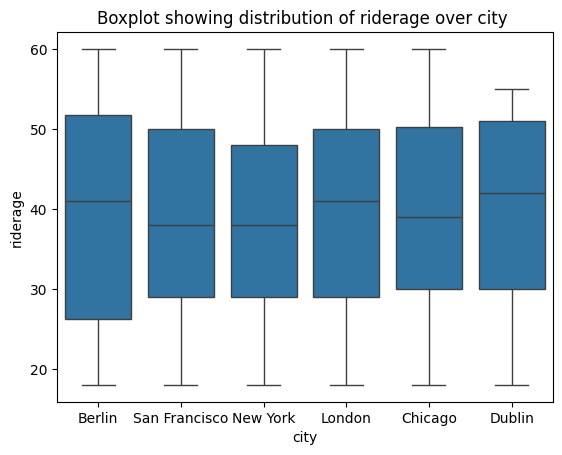

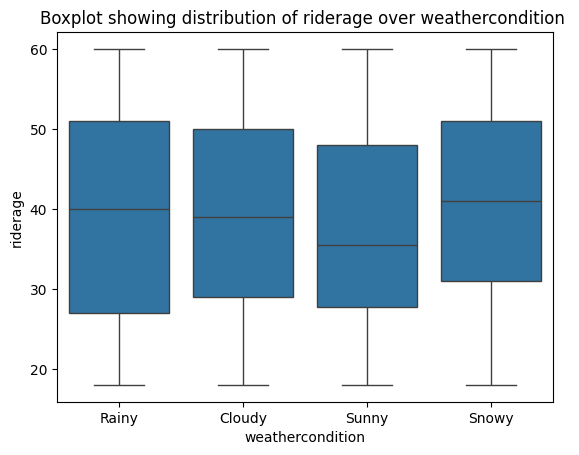

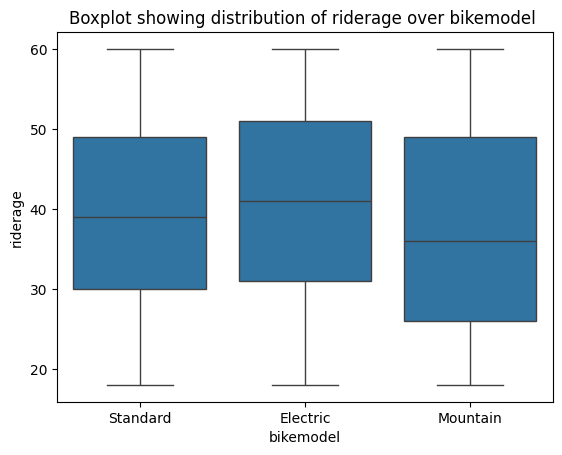

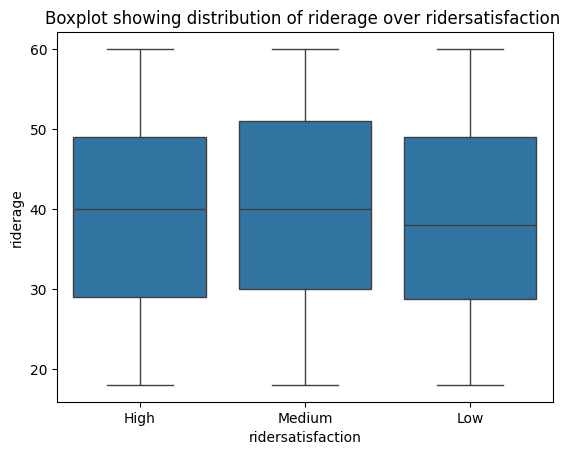

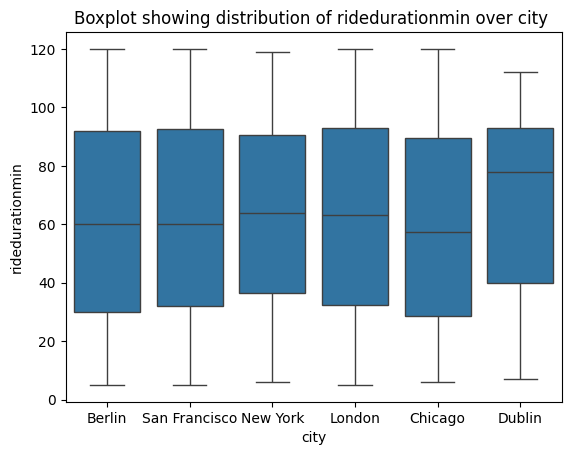

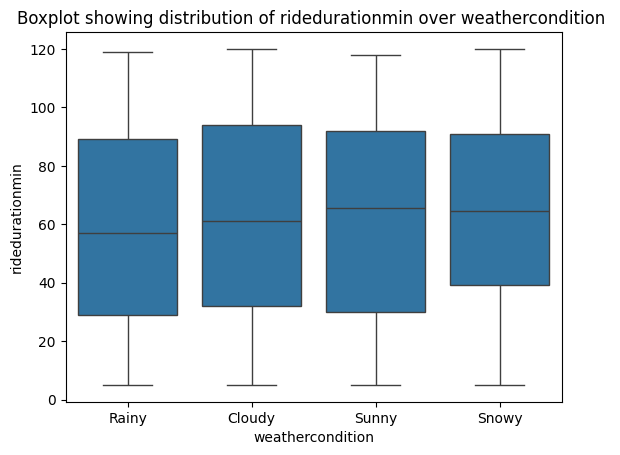

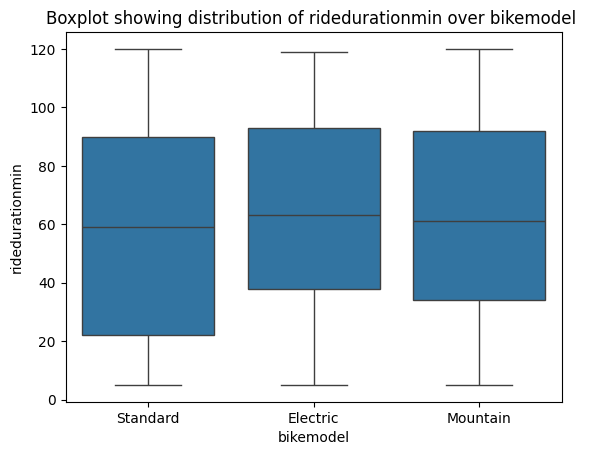

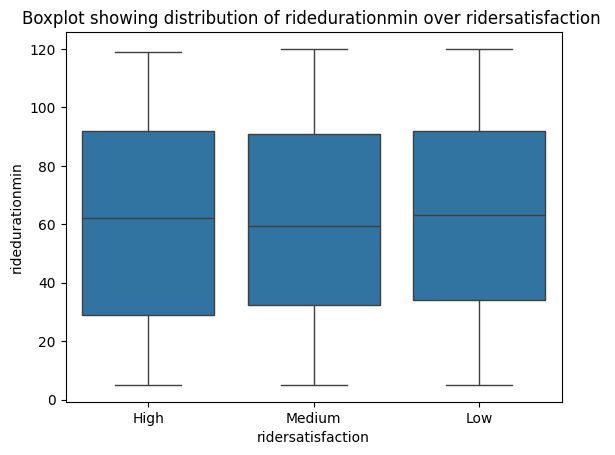

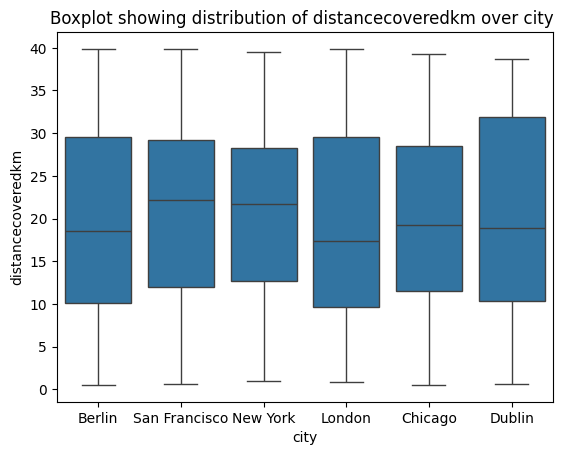

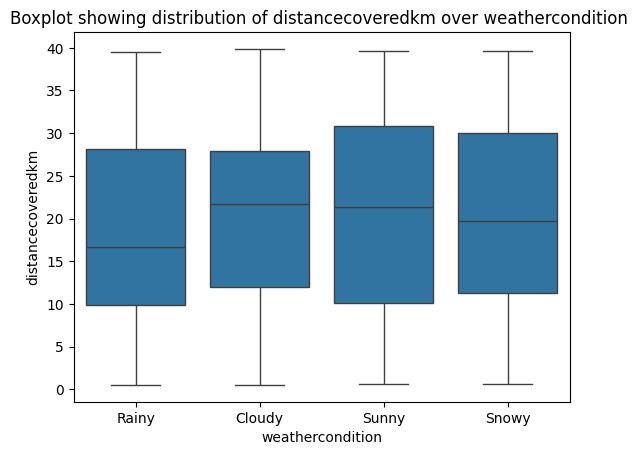

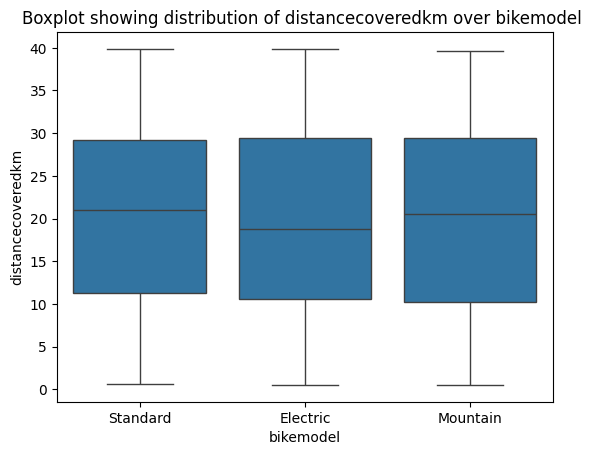

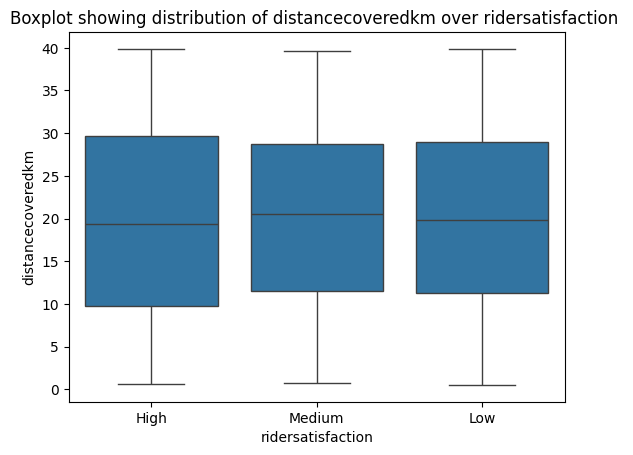

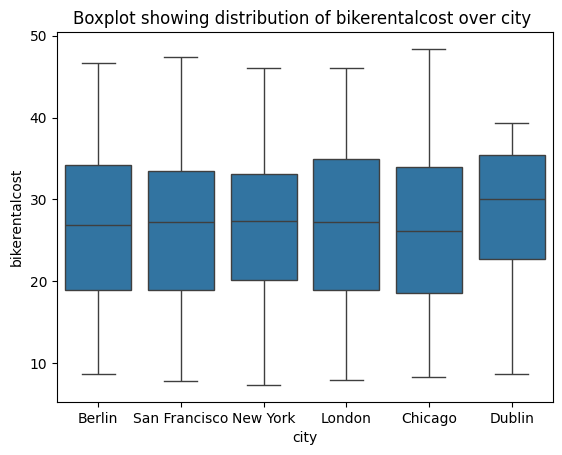

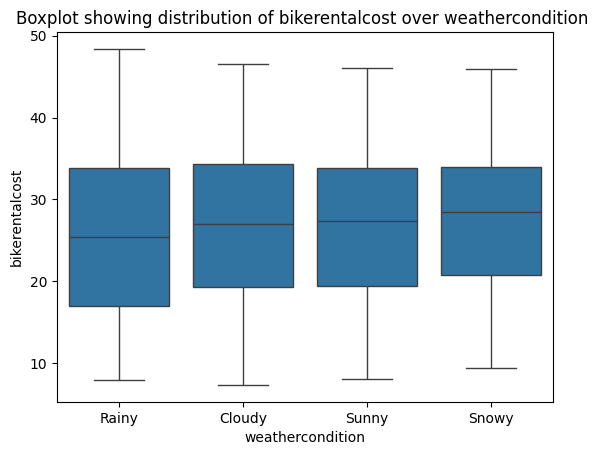

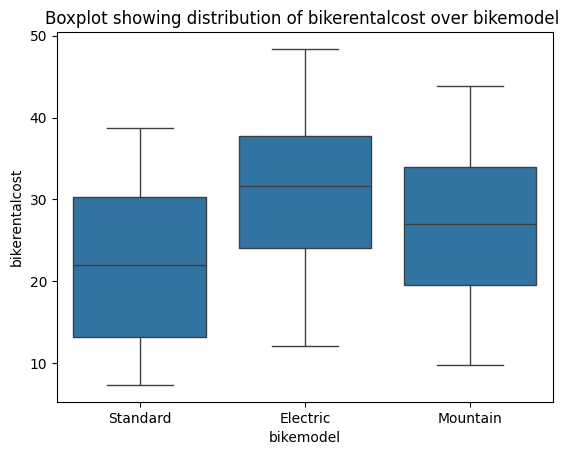

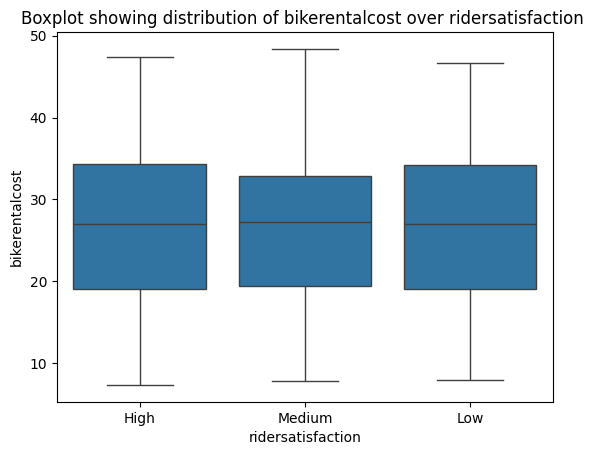

In [19]:
for i in range(len(numeric_columns)):
    for j in range(len(categorical_columns)):
        col1 = numeric_columns[i]
        col2 = categorical_columns[j]
        # Categorical vs Numerical Analysis
        sns.boxplot(x=col2, y=col1, data=cleaned_df)
        plt.title(f'Boxplot showing distribution of {col1} over {col2} ')
        plt.show()


### Feature Engineering, Encoding, Scaling

This step involves transforming all initial columns to numerical formats that can be used in the numerical methods
such as PCA, LDA and machine learning.



#### Transforming categorical columns

In [57]:
categorical_columns

Index(['city', 'weathercondition', 'bikemodel', 'ridersatisfaction'], dtype='object')

In [58]:
# we map each categorical column to dummy values
# the intuition is that each value of each category will become a column with a boolean(0/1) value
# this seems a better approach than label encoding since most of the categorical columns
# do not have many categories, so an increase in dimensionality is not an issue here.
# For example label encoding "City" would be problematic
cleaned_df_dummies = pd.get_dummies(cleaned_df, columns=categorical_columns, drop_first = True).reset_index(drop=True)
print(cleaned_df_dummies.columns)
print(cleaned_df_dummies.shape)

Index(['riderage', 'ridedurationmin', 'distancecoveredkm', 'bikerentalcost',
       'city_Chicago', 'city_Dublin', 'city_London', 'city_New York',
       'city_San Francisco', 'weathercondition_Rainy',
       'weathercondition_Snowy', 'weathercondition_Sunny',
       'bikemodel_Mountain', 'bikemodel_Standard', 'ridersatisfaction_Low',
       'ridersatisfaction_Medium'],
      dtype='object')
(852, 16)


#### Transforming numeric columns

In [37]:
numeric_columns

Index(['riderage', 'ridedurationmin', 'distancecoveredkm', 'bikerentalcost'], dtype='object')

In [38]:
# we map each numeric column to a standard normal distribution
# the intuition is that each value is subtracted by the mean and divided by the standard deviation
numeric_data = cleaned_df[numeric_columns]
wholedata_scaler = StandardScaler()
wholedata_scaler.fit(numeric_data)
scaled_numeric_data = wholedata_scaler.transform(numeric_data)
scaled_numeric_df = pd.DataFrame(scaled_numeric_data, columns=numeric_columns).reset_index(drop=True)


## IDEALLY we should train the scaler in the training data
## and use in the test data
## Since our dimensionality reduction does not split train and test data
## we are training the standard scaler with all the dataset
#scaler = StandardScaler()
# Train the StandardScaler model
#scaler.fit(X_train)
#
# transform data
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled  = scaler.transform(X_test)


In [39]:
numeric_columns

Index(['riderage', 'ridedurationmin', 'distancecoveredkm', 'bikerentalcost'], dtype='object')

In [40]:
scaled_numeric_df.shape

(852, 4)

#### Concatenating both generated features into a single Features Dataframe

In [61]:
cleaned_df_X = pd.concat([scaled_numeric_df, cleaned_df_dummies], axis=1)

In [62]:
cleaned_df_X.shape

(852, 20)

#### Y-labels for LDA (classifying customer satisfaction)

In [111]:
# Creating a features without satisfaction columns
# dropping any column that has "ridersatisfaciton"
# Using label enconder 
customersatisfaction_label_encoder = LabelEncoder()
ridersatisfaction_columns=[col for col in cleaned_df_X.columns if 'ridersatisfaction' in col]
customersatisfaction_X = cleaned_df_X.drop(columns=ridersatisfaction_columns)
customersatisfaction_y = customersatisfaction_label_encoder.fit_transform(cleaned_df['ridersatisfaction'])
target_names = customersatisfaction_label_encoder.classes_

### Dimensionality Reduction

#### The intuition in dimensionality reduction is finding a reduced vector representation of our data usually it is explored in two ways:

    1. Find a reduced representation that discrimates well certain classes.
    2. Find a reduced representation that explains great part of the variance of the features


### 1. Dimensionality reduction for classifying customer satisfaction



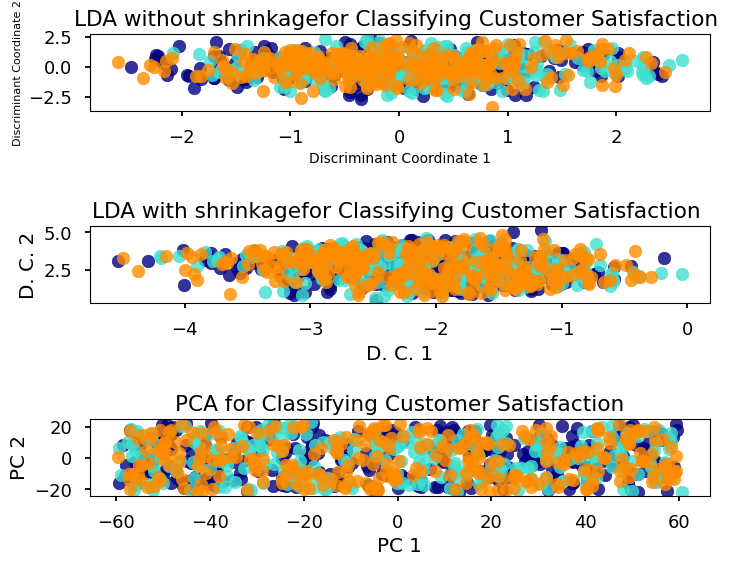

In [112]:
X = customersatisfaction_X
y = customersatisfaction_y

X_r_lda = LinearDiscriminantAnalysis(n_components=2).fit(X, y).transform(X)
X_r_lda_with_shrinkage = LinearDiscriminantAnalysis(n_components=2, solver='eigen', shrinkage=0.1).fit(X, y).transform(X)
X_r_pca = PCA(n_components=2).fit(X).transform(X)

with plt.style.context('seaborn-talk'):
    fig, axes = plt.subplots(3,1,figsize=[8,6])
    colors = ['navy', 'turquoise', 'darkorange']
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        axes[0].scatter(X_r_lda[y == i, 0], X_r_lda[y == i, 1], alpha=.8, label=target_name, color=color)
        axes[1].scatter(X_r_lda_with_shrinkage[y == i, 0], X_r_lda_with_shrinkage[y == i, 1], alpha=.8, label=target_name, color=color)
        axes[2].scatter(X_r_pca[y == i, 0], X_r_pca[y == i, 1], alpha=.8, label=target_name, color=color)
    axes[0].title.set_text('LDA without shrinkagefor Classifying Customer Satisfaction ')
    axes[1].title.set_text('LDA with shrinkagefor Classifying Customer Satisfaction ')
    axes[2].title.set_text('PCA for Classifying Customer Satisfaction')
    axes[0].set_xlabel('Discriminant Coordinate 1',fontsize=10)
    axes[0].set_ylabel('Discriminant Coordinate 2',fontsize=8)
    axes[1].set_xlabel('D. C. 1')
    axes[1].set_ylabel('D. C. 2')
    axes[2].set_xlabel('PC 1')
    axes[2].set_ylabel('PC 2')
    fig.subplots_adjust(hspace=1.5)

### 2. Using PCA to analyze explained variance of the data



In [ ]:
pca=PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of features')
plt.ylabel('cumulative explained variance')
print(np.cumsum(pca.explained_variance_ratio_))

## Machine Learning


When we can those features we call the dataframe a "X" for the features and "y" for the target label. 

This dataset has different potentials to be analyzed using dimension reduction, unsupervised and supervised learning.
For example
    1- Can we predict rider satisfaction ?
    2- Are there clusters of high paying customers ?

I will first generate the numerical features to analyze those questions in the machine learning section


## Ideas to investigate
#### Are people overall satistified ?
#### People satisfaction is almost even between low, medium and high
#### What are the most profitables regions ?
#### What are the regions with higher and lower satisfcation ?
#### Do satisfied people pay more ? less ?


In [ ]:
targets=['ridersatisfaction','bikerentalcost']
for col in targets:
    print(df[col].value_counts())


In [ ]:
df['bikerentalcost'].describe()

In [ ]:
df['bikerentalcost'].hist()

In [ ]:

ax = df[targets].plot.box()

In [ ]:
df['ridersatisfaction'].value_counts()[['Low','Medium','High']].plot(kind='bar')

In [ ]:
df['ridersatisfaction'].value_counts()

## References

https://stackoverflow.com/questions/18500011/horizontal-box-plots-in-matplotlib-pandas

https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value

https://seaborn.pydata.org/generated/seaborn.heatmap.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html